In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("ensemble_hist.csv", names=["name", "count"], skiprows=1)
bins = [0, 1, 5, 10, 100, 1000, df["count"].max()]
counts = pd.cut(df["count"], bins=bins).value_counts(sort=False)
counts

count
(0, 1]           42018
(1, 5]           62571
(5, 10]          33782
(10, 100]        66948
(100, 1000]      21249
(1000, 23725]     1632
Name: count, dtype: int64

Text(0.5, 0, '')

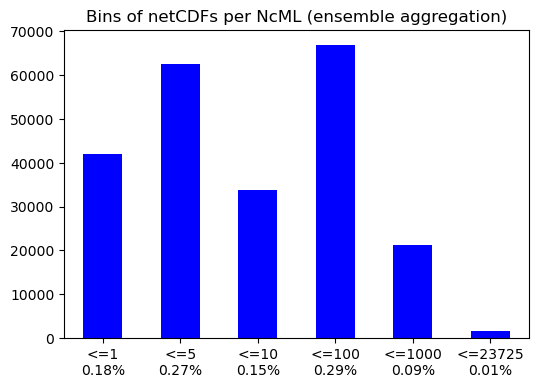

In [3]:
ax = counts.plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels(["<={}\n{}%".format(c.right, round(v/len(df),2)) for c,v in zip(counts.index.categories, counts.values)])
ax.set_title("Bins of netCDFs per NcML (ensemble aggregation)")
ax.set_xlabel("")

In [4]:
df[df["count"] == df["count"].max()].name.values

array(['CMIP6_HighResMIP_BCC_BCC-CSM2-HR_hist-1950_6hrLev_hus_gn_v20201019_cmip.bcc.cma.cn'],
      dtype=object)

In [5]:
df = pd.read_csv("variable_hist.csv", names=["name", "count"], skiprows=1)
bins = [0, 1, 5, 10, 100, 1000, df["count"].max()]
counts = pd.cut(df["count"], bins=bins).value_counts(sort=False)
counts

count
(0, 1]           779121
(1, 5]           285350
(5, 10]           73958
(10, 100]        136711
(100, 1000]       17600
(1000, 23725]       593
Name: count, dtype: int64

Text(0.5, 0, '')

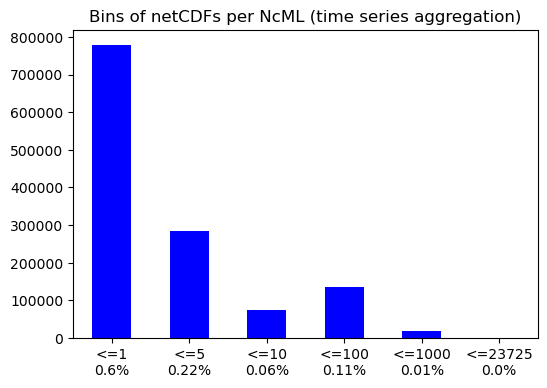

In [6]:
ax = counts.plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels(["<={}\n{}%".format(c.right, round(v/len(df),2)) for c,v in zip(counts.index.categories, counts.values)])
ax.set_title("Bins of netCDFs per NcML (time series aggregation)")
ax.set_xlabel("")

In [7]:
df[df["count"] == df["count"].max()].name.values

array(['CMIP6_HighResMIP_BCC_BCC-CSM2-HR_hist-1950_r1i1p1f1_6hrLev_hus_gn_v20201019_cmip.bcc.cma.cn'],
      dtype=object)